# Rationale

This document shows you how to analyze our example data with python using linear mixed effects models. It gives you an idea of common packages in the scientific python community. Some of these are without alternative, others (like the plotting library) are very much subject to personal preference. It is also meant as an example of how notebooks are a really nice way to mix analysis code and personal comments and plots. You can take this as far as drafting a paper interleaved with code.

# Grab the data

First, we will get the data that we had in our csv format:

In [1]:
import pandas as pd
import seaborn as sns # plotting
import statsmodels.api as sm # plotting and regression
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

# This is strictly for the jupyter notebook. It lets you control what parts of the code 
# should be rendered as output.
# InteractiveShell.ast_node_interactivity : ‘all’|’last’|’last_expr’|’none’
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all" # Print all expression output  

import os
df = pd.read_csv("./results/01.csv") # read one as base data frame
for file in os.listdir("./results"): # grab all other files in folder
    if file in ["01.csv", ".gitkeep"]:
        continue # skip the one you already have
    # merge them into the data frame one by one
    df = pd.concat([df, pd.read_csv(os.path.join("./results", file))], axis=0)

df.head()
df.describe()

Subject      Trial          rt
count  96.000000  96.000000    96.00000
mean    4.500000   6.500000   601.93750
std     2.303316   3.470174   107.20495
min     1.000000   1.000000   448.00000
25%     2.750000   3.750000   528.50000
50%     4.500000   6.500000   581.50000
75%     6.250000   9.250000   649.00000
max     8.000000  12.000000  1110.00000

# Pre-processing

First, we need to get the data into shape for processing. This usually involves:

* Outlier removal
* Scaling
* Dealing with empty data and other bugs
* Some formatting required by the final model running the data (one-hot-encoding, factors as numerics)

In our example, we already have a relatively clean data set because i created it by hand. Still, as a first step it is prudent to look at the data to get an impression if all is well. Lets plot the raw reaction times and inspect condition means.

/home/florian/.conda/envs/flo-basic/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


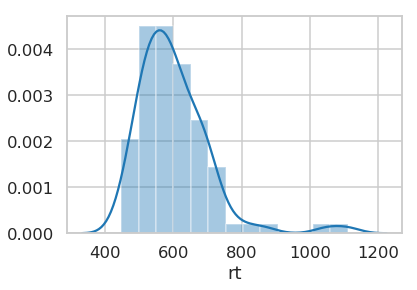

In [3]:
InteractiveShell.ast_node_interactivity = "last"

sns.set_style('whitegrid')
sns.set_context('talk') # size of your axis labels: try 'poster' and 'paper' instead

sns.distplot(df["rt"])


In [4]:
df.head()
df.groupby(['Congruency', 'Direction']).mean()

Subject  Trial        rt
Congruency  Direction                          
congruent   left           4.5    4.0  576.1250
            right          4.5    7.0  546.8750
incongruent left           4.5    8.0  645.7500
            right          4.5    5.0  686.6250
neutral     left           4.5    6.0  599.6875
            right          4.5    9.0  556.5625

## Dealing with outliers

This distribution looks like we need to deal with outliers. I have not been able to find any nice built-in functions to do outlier removal. We are dealing with reaction times. From my work in cooperations I remembered that it is a community standard to use some kind of outlier removal such as __[Tukey's method](https://en.wikipedia.org/wiki/Outlier#Tukey's_fences)__. This method removes outliers iteratively based on the interquartile range. It is easy enough to implement it ourselves.

There are other ways to deal with this. If this were fixation durations, the community standard would be to log-transform the data first and only then remove outliers. We can just do both and store the results in different columns.

To be able to follow both approaches, we don't really remove any data from the data frame but simply _flag_ the data with an indexer column. Based on this column, we can remove things as whenever we need it but also retain the entire data. You can see an example of how to filter just as it's needed in the plot below.

### Remove outliers with Tukey

In [5]:
def flag_outliers_tukey(series, scaler=1.5):
    """
    Takes a series and returns indices of data that are outliers according to
    tukeys method.
    """
    series_clean = series  # work on copy, retain original
    is_outlier = [True]
    while any(is_outlier):
        print("Flagging outliers (again)")

        q75, q25 = np.percentile(series_clean, [75 ,25])
        iqr = q75-q25 # inter-quartile-range
        lower_fence = q25 - scaler*iqr
        upper_fence = q75 + scaler*iqr
        print("Borders [{0:f}, {1:f}]".format(lower_fence, upper_fence))

        # detect outliers
        is_outlier = series_clean.apply(lambda x: (x < lower_fence) | (x > upper_fence))

        # shrink series
        series_clean = series_clean[~is_outlier]

    print("No more outliers found. Final borders [{0:f}, {1:f}]".format(lower_fence, upper_fence))
    return series.apply(lambda x: (x < lower_fence) | (x > upper_fence))

Now that we have our function, let's run it on the data and plot the resulting distribution. This time, we will use a quantile-quantile plot to judge normality.

Flagging outliers (again)
Borders [347.750000, 829.750000]
Flagging outliers (again)
Borders [360.500000, 804.500000]
Flagging outliers (again)
Borders [359.250000, 805.250000]
No more outliers found. Final borders [359.250000, 805.250000]


Text(0.5, 1.0, 'After cleansing')

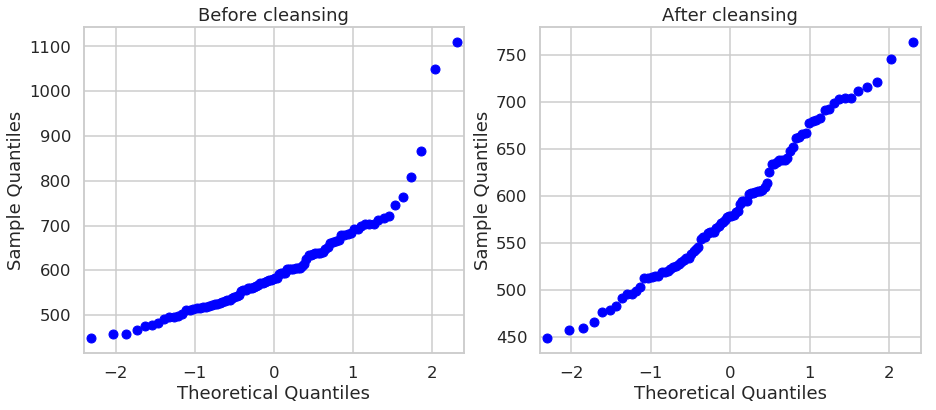

In [6]:
df['is_outlier'] = flag_outliers_tukey(df['rt'])

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
sm.qqplot(df['rt'], stats.norm, ax=axes[0])
axes[0].set_title('Before cleansing')

sm.qqplot(df[~df['is_outlier']]['rt'], stats.norm, ax=axes[1])
axes[1].set_title('After cleansing')

As we can see, the top values have been removed. Two of them in the first run, two more in the second run. The data are now reasonably close to a normal distribution. With as little data as we have, we might want to check that we did not remove only data points from a single condition. In any experiment that you do in the real world, I hope you have enough data not to care about this problem in the first place.

In [7]:
df.groupby(['is_outlier', 'Direction', 'Congruency']).count()

Subject  Trial  Stimulus  CorrectAnswer  rt
is_outlier Direction Congruency                                              
False      left      congruent         16     16        16             16  16
                     incongruent       15     15        15             15  15
                     neutral           16     16        16             16  16
           right     congruent         16     16        16             16  16
                     incongruent       13     13        13             13  13
                     neutral           16     16        16             16  16
True       left      incongruent        1      1         1              1   1
           right     incongruent        3      3         3              3   3

Judging from this, I would say the data are still balanced enough. Let's now do the log transformation and plot all distributions to compare and contrast.

## Log transforming the data

In [8]:
df['rt_log'] = np.log(df['rt'])
df['log_is_outlier'] = flag_outliers_tukey(df['rt_log'])

sns.set_style('whitegrid')
sns.set_context('talk') # size of your axis labels: try 'poster' and 'paper' instead

fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

sns.distplot(df["rt"], ax=axes[0,0])
axes[0,0].set_title('Raw')

sns.distplot(df[~df["is_outlier"]]["rt"], ax=axes[0,1])
axes[0,1].set_title('Outliers removed')

sns.distplot(df["rt_log"], ax=axes[1,0])
axes[1,0].set_title('Log transformed')

sns.distplot(df[~df["log_is_outlier"]]["rt_log"], ax=axes[1,1])
axes[1,1].set_title('Log transformed w/o outliers')


Flagging outliers (again)
Borders [5.961960, 6.783511]
Flagging outliers (again)
Borders [5.979340, 6.749493]
Flagging outliers (again)
Borders [5.980494, 6.745045]
No more outliers found. Final borders [5.980494, 6.745045]


Text(0.5, 1.0, 'Log transformed w/o outliers')

In a real world example, I would probably go for the raw data with outliers removed. Log-transformation does not seem to save us a lot of data points, so dealing with the data on an original scale is probably best.

## Scaling the data

Now that we are more happy with the resulting distribution, let's choose one of them and center it around 0. This has the advantage that the _intercept_ term in our linear model will become meaningful: It will represent the grand mean. Scaling is not necessary, since we do not have data of different units or different scale. Scaling can be done handily with the `sklearn` package.

In [13]:
from sklearn.preprocessing import StandardScaler

# grab the raw values, then turn them into a two-dimensional ndarray so that sklearn scaler can work with it
# this is an example where object oriented programming is very annoying
log_data = df['rt_log'].values.reshape(96,1) 
scaler = StandardScaler(with_mean=True, with_std=False).fit(log_data)

df['rt_log_c'] = scaler.transform(log_data)

data = df['rt'].values.reshape(96,1) 
scaler = StandardScaler(with_mean=True, with_std=False).fit(data)

df['rt_c'] = scaler.transform(data)


df.describe()

/home/florian/.conda/envs/flo-basic/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/florian/.conda/envs/flo-basic/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Subject      Trial          rt     rt_log      rt_log_c       rt_c
count  96.000000  96.000000    96.00000  96.000000  9.600000e+01   96.00000
mean    4.500000   6.500000   601.93750   6.386671 -3.793262e-16    0.00000
std     2.303316   3.470174   107.20495   0.159935  1.599353e-01  107.20495
min     1.000000   1.000000   448.00000   6.104793 -2.818778e-01 -153.93750
25%     2.750000   3.750000   528.50000   6.270041 -1.166296e-01  -73.43750
50%     4.500000   6.500000   581.50000   6.365608 -2.106343e-02  -20.43750
75%     6.250000   9.250000   649.00000   6.475429  8.875808e-02   47.06250
max     8.000000  12.000000  1110.00000   7.012115  6.254442e-01  508.06250

As we can see, the transformed data have a mean of 0 (an infinitely small float close to 0). We are now ready to model the data.

# Modeling the data

Let's start with an ordinary least squares regression including an intercept term and the two experimental predictors.

In [15]:
import statsmodels.formula.api as smf

# let's do it with the original data for informative purposes
m1 = smf.ols(formula="rt_c ~ 1 + Congruency * Direction", data=df[~df["is_outlier"]]).fit()

print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                   rt_c   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     3.543
Date:                Mon, 19 Nov 2018   Prob (F-statistic):            0.00584
Time:                        15:29:14   Log-Likelihood:                -517.47
No. Observations:                  92   AIC:                             1047.
Df Residuals:                      86   BIC:                             1062.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

There doesn't seem to be an effect in our experiment at first sight. Let's check it with a linear mixed effects model that controls for Subject variations in the intercept.

In [14]:
lmm1 = smf.mixedlm(formula="rt_c ~ 1 + Congruency + Direction", data=df[~df["is_outlier"]], 
                   groups=df[~df["is_outlier"]]["Subject"]).fit(method='nm')
print(lmm1.summary())

lmm2 = smf.mixedlm(formula="rt_c ~ 1 + Congruency * Direction", data=df[~df["is_outlier"]], 
                   groups=df[~df["is_outlier"]]["Subject"]).fit(method='nm')
print(lmm2.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      rt_c     
No. Observations:      92           Method:                  REML     
No. Groups:            8            Scale:                   4544.1793
Min. group size:       10           Likelihood:              -504.2473
Max. group size:       12           Converged:               Yes      
Mean group size:       11.5                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                 -29.799   15.266 -1.952 0.051 -59.721  0.122
Congruency[T.incongruent]  64.093   17.534  3.655 0.000  29.728 98.459
Congruency[T.neutral]      16.625   16.853  0.986 0.324 -16.406 49.656
Direction[T.right]        -21.276   14.074 -1.512 0.131 -48.860  6.307
Group Var              

# Conclusion

A lot of things can be done with python for analyzing data. I do not want to recommend any solution over any other. Instead, I would like to give you a few points to think about when it comes to choosing what you use for analysis:

* **Is it the community standard in my field?** To me the most important thing of all. I do regression type analyses in R because they have `mgcv`, but convolutional neural networks in python because there is the `tensorflow` package. If a package is used by many people, it is usually better maintained and has more funcitonality out of the box. For example, I have neither found likelihood ratio tests for LMM's nor contrast coding capabilities in `statsmodels` or any of the other packages in python. Also, more people can help you with that package. 
* **Do I want everything in one language?** This is a nice idea in principle. If your experiment is coded in python, why not also analyze data in python? But I have found that analysis software, especially `pandas`, is pretty much like learning a new language anyways. Indexing is different, vectorized code is preferred over for loops: It is very much emulating R. So instead of the swiss army knife with a mini-hammer attached to it, you might as well use the proper hammer to punch nails in. 
* **Do I use a pre-made solution or do I write new things?** If someone has already solved a problem nicely and you just want to use it, use the community standard. If you need to write something completely new, python is very likely your language of choice. It is a wonderfully accessible, free general purpose tool with a huge community and no matter what other people say: Google is based on python. What more argument do you need?

One thing you should certainly do: Get your data into csv format. This is your interface between any of the languages you want to use. Every language can read it, every language can write it.